### Simple Energy Balance on Venus

Here we'll create a simple energy balance model for Venus to derive a simple surface temperature:

$T_s = \left(\frac{(1-A)S}{4 \epsilon \sigma}\right)^{1/4}$

where we assume $\epsilon \approx 0.01$, $A \approx 0.75$, and $S = 2614$ W/m$^2$.

In [23]:
from astropy.constants import sigma_sb  # Stefan-Boltzmann constant
from astropy import units as u

# Constants
S = 2614 * (u.W / u.m**2)  # Solar constant at Venus
A = 0.75  # Albedo of Venus
epsilon = 0.01
# Effective emissivity
sigma = sigma_sb  # Stefan-Boltzmann constant

# Energy balance equation to solve for Ts (surface temperature)
Ts = (((1 - A) * S / (4 * epsilon * sigma)) ** 0.25).to(u.K)
print(f"Surface Temperature (Ts): {Ts:.2f}")


Surface Temperature (Ts): 732.64 K


Or, as a simple function:

In [ ]:
# Function to calculate surface temperature Ts for a given solar constant S
def calculate_surface_temperature(S, A=0.75, epsilon=0.01):
    """
    Calculate the surface temperature (Ts) for a given solar constant (S).
    
    Parameters:
    - S: Solar constant (W/m^2) [Astropy quantity with units]
    - A: Planetary albedo (default: 0.75)
    - epsilon: Effective emissivity of the atmosphere (default: 0.01)
    
    Returns:
    - Ts: Surface temperature (K) [Astropy quantity with units]
    """
    Ts = (((1 - A) * S / (4 * epsilon * sigma_sb)) ** 0.25).to(u.K)
    return Ts

### Atmospheric Temperature Gradient Equation

The atmospheric temperature gradient can be expressed as:

$
\frac{dT}{dp} = \frac{1}{c_p(T)} \frac{RT}{p \mu}
$

#### Variables:
- **T**: Temperature (K) at a given pressure level in the atmosphere.
- **p**: Pressure (Pa), which decreases with altitude in the atmosphere.
- **$c_p(T)$**: Specific heat capacity at constant pressure, dependent on temperature and atmospheric composition.
- **R**: Universal gas constant.
- **$\mu$**: Mean molecular weight of the atmosphere, determined by the atmospheric composition.

This equation describes how temperature changes with pressure in an atmosphere, accounting for the energy balance between thermal energy and atmospheric composition. The pressure decreases with altitude, causing a corresponding change in temperature as described by this gradient.


In [31]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import R as R_astropy
from astropy import units as u
import import_ipynb
from RKF12 import rkf12  

# Define constants with Astropy units
R = R_astropy.to(u.J / (u.mol * u.K))  # Universal gas constant (J/(mol K))
mu = 2 * u.g / u.mol  # Mean molecular weight, example for H2-dominated atmosphere
p0 = 1e5 * u.Pa  # Initial pressure in Pascals
T0 = Ts  # Initial temperature in Kelvin
p_end = 1e3 * u.Pa  # Final pressure in Pascals
h_init = 1000 * u.Pa  # Initial step size in Pascals
tol = 1e-5  # Tolerance for adaptive step size (dimensionless)

# Define temperature-dependent specific heat capacity (c_p) with units
def c_p(T):
    return (20.8 + 0.02 * T.value) * (u.J / (u.mol * u.K))  # Example model

# Define the differential equation dT/dp with units
def dT_dp(p, T):
    return ((R * T) / (p * mu * c_p(T))).to(u.K/u.Pa)

# Convert units to simplify computation in rkf12
def dT_dp_dimensionless(p, T):
    p = p * u.Pa
    T = T * u.K
    result = dT_dp(p, T)#.to(u.K / u.Pa)  # Convert to base units for integration
    return result.value

# Solve the ODE using RKF12
p_values, T_values = rkf12(dT_dp_dimensionless, p0.value, T0.value, p_end.value, h_init.value, tol)

# Convert results back to units
p_values = p_values * u.Pa
T_values = T_values * u.K

# Print the results
print(f"Temperature values: {T_values}")
print(f"Pressure values: {P_values}")


Temperature values: [732.64479067] K
Pressure values: [100000.          91029.81779915  82864.27728547  75431.20063355
  68664.88450043  62505.51925274  56898.66029018  51794.74679231
  47148.66363457  42919.34260129  39069.39937055  35564.80306223
  32374.57542818  29470.51702552  26826.9579528   24420.53094549
  22229.96482526  20235.89647725  18420.69969327  16768.32936811
  15264.17967175  13894.95494373  12648.55216855  11513.95399326
  10481.13134155   9540.9547635    8685.11373751   7906.04321091
   7196.85673001   6551.2855686    5963.62331659   5428.67543932
   4941.71336132   4498.43266897   4094.91506238   3727.59372031
   3393.2217719    3088.84359648   2811.76869797   2559.5479227
   2329.95181052   2120.95088792   1930.69772888   1757.51062485
   1599.85871961   1456.3484775    1325.71136559   1206.79264064
   1098.54114199   1000.        ] Pa


If we vary S over time:

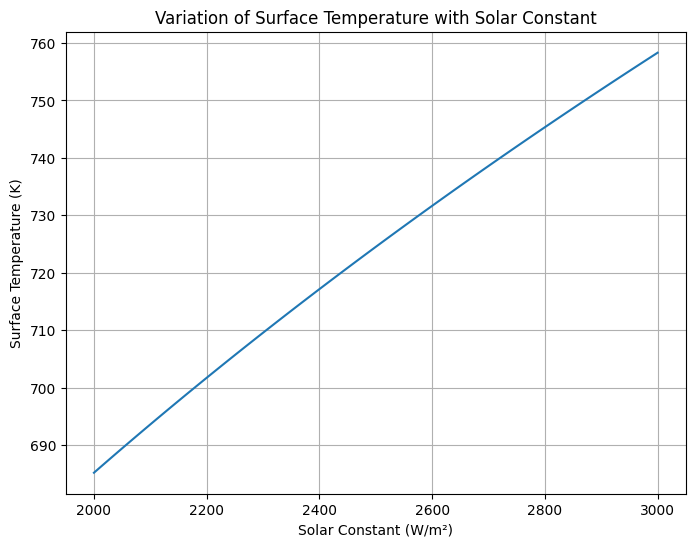

In [28]:
from astropy.constants import sigma_sb  

# Constants
A = 0.75  # Albedo of Venus
epsilon = 0.01  # Effective emissivity of the atmosphere

# Varying the solar constant (S) and calculating Ts
S_values = np.linspace(2000, 3000, 100) * (u.W / u.m**2)  # Solar constants in W/m^2
Ts_values = [calculate_surface_temperature(S) for S in S_values]

# Convert to dimensionless for plotting
S_values_plot = S_values.value
Ts_values_plot = [Ts.value for Ts in Ts_values]

# Plotting S vs. Ts
plt.figure(figsize=(8, 6))
plt.plot(S_values_plot, Ts_values_plot)
plt.xlabel("Solar Constant (W/m²)")
plt.ylabel("Surface Temperature (K)")
plt.title("Variation of Surface Temperature with Solar Constant")
plt.grid()
plt.show()
